Building on the exploration and analysis done in assignment 1.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score

Mounted at /content/drive


In [4]:
# Load the data - already merged data from the test group as they were  to have been empathetic 
df = pd.read_csv('/content/drive/MyDrive/Eye empathy/test_merged.csv')
quest_df = pd.read_csv('/content/drive/MyDrive/Eye empathy/Questionnaire_datasetIA.csv', encoding='latin-1')

<ipython-input-4-04c2544e397b>:2: DtypeWarning: Columns (0,1,2,12,16,17,19,20,21,22,23,24,25,26,27,34,35,56,57,58,59,60,61,63,64,65,66,67,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Eye empathy/test_merged.csv')


In [5]:
df.head()

,Unnamed: 0,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Participant name,Recording name,Recording date,Recording date UTC,...,Original Media height,Eye movement type,Gaze event duration,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y
0,3082.0,23419315,512092386,NaN,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,...,NaN,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN
1,3083.0,23419315,512092386,NaN,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,...,NaN,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN
2,3084.0,23426120,512099191,Eye Tracker,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,...,649.0,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN
3,3085.0,23434449,512107520,Eye Tracker,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,...,649.0,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN
4,3086.0,23442782,512115853,Eye Tracker,Test group experiment,29.10.2020,Participant0001,Recording1,24.09.2020,24.09.2020,...,649.0,Fixation,117.0,64.0,971.0,341.0,"0,5073","0,3160",NaN,NaN


In [6]:
# Drop columns that are irrelevant or too sparse 
columns_to_drop = ['Sensor', 'Recording timestamp', 'Computer timestamp', 'Export date',
                   'Recording name', 'Recording date', 'Timeline name', 'Recording Fixation filter name', 
                   'Mouse position X', 'Mouse position Y', 'Recording software version', 'Event', 'Event value', 
                   'Project name', 'Presented Media name', 'Presented Stimulus name', 'Unnamed: 0', 'Eyetracker timestamp', 
                   'Recording start time UTC', 'Recording date UTC', 'Project name', 'Gaze point X (MCSnorm)', 
                   'Gaze point Y (MCSnorm)', 'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)', 
                   'Gaze point right X (MCSnorm)', 'Gaze point right Y (MCSnorm)', 'Fixation point X', 'Fixation point Y', 
                   'Fixation point X (MCSnorm)', 'Fixation point Y (MCSnorm)']

df.drop(columns_to_drop, axis=1, inplace=True)


In [7]:
# Drop rows with null values in 'Pupil diameter left' and 'Pupil diameter right' as they are the main features to be used. 
df = df.dropna(subset=['Pupil diameter left', 'Pupil diameter right'])


# Drop rows where 'Participant name' is 'Participant name'
df = df[df['Participant name'] != 'Participant name']

# Extract participant number from 'Participant name' column
df['id'] = df['Participant name'].apply(lambda x: int(x[-2:]) if isinstance(x, str) else 'NaN')
df.drop('Participant name', axis= 1, inplace = True)

In [8]:
df['Eye movement type'].value_counts()

Fixation        519983
Saccade         182388
Unclassified     99477
Name: Eye movement type, dtype: int64

<Axes: >

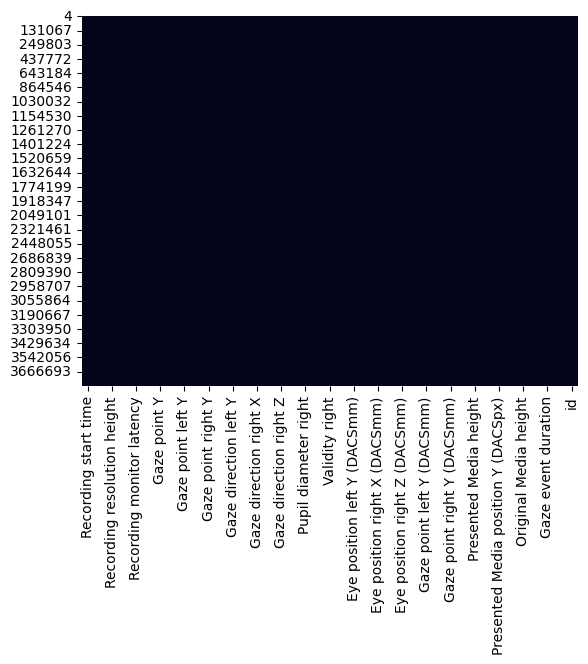

In [9]:
# Manual label encoding of 'Eye movement type' column
eye_movement_dict = {'Fixation': 0, 'Saccade': 1, 'Unclassified': 2, 'EyesNotFound': 3}
df['Eye movement type'] = df['Eye movement type'].map(eye_movement_dict)

# Visualize sparsity of remaining features
sns.heatmap(df.isnull(), cbar=False)

In [10]:
#mapping empathy scores from the questionnaire dataset
score_dic = dict(zip(quest_df['Participant nr'], quest_df['Total Score original']))
df['Empathy scores'] = [score_dic.get(i) for  i in df.id]

In [11]:
df['Empathy scores'].value_counts()

81     141200
108    141156
106     95093
87      73632
100     56843
90      47273
79      29544
109     26197
111     25325
107     25241
103     24953
94      22069
96      16416
83      15734
92      15083
104     14310
86      12269
97       9737
75       6504
101      1606
99       1425
80        238
Name: Empathy scores, dtype: int64

In [12]:
#the DACSmm features are all in coordinate format and will be dropped 

In [13]:
df['Eye position left Y (DACSmm)'][0:6]

4     76,9
7     76,9
10    76,9
13    76,9
16    76,8
19    76,9
Name: Eye position left Y (DACSmm), dtype: object

In [14]:
df.drop(['Eye position left Y (DACSmm)', 'Eye position left Z (DACSmm)',
       'Eye position right X (DACSmm)', 'Eye position right Y (DACSmm)',
       'Eye position right Z (DACSmm)', 'Gaze point left X (DACSmm)',
       'Gaze point left Y (DACSmm)', 'Gaze point right X (DACSmm)',
       'Gaze point right Y (DACSmm)','Eye position left X (DACSmm)'], inplace = True, axis = 1)

In [15]:
df['Gaze direction right Z'][10]

'-0,99980'

In [16]:
#the gaze directions also are coordinates, 

In [17]:
df.drop(['Gaze direction left X', 'Gaze direction left Y',
       'Gaze direction left Z', 'Gaze direction right X',
       'Gaze direction right Y', 'Gaze direction right Z'], axis = 1, inplace = True)

In [18]:
#dropping columns not needed or having repeated data
df.drop(['Recording start time','Recording resolution height', 'Recording resolution width',
       'Recording monitor latency','Presented Media width',
       'Presented Media height','Gaze event duration'], axis = 1, inplace = True)


In [19]:
df[['Validity left', 'Validity right']].describe()

,Validity left,Validity right
count,801848,801848
unique,1,1
top,Valid,Valid
freq,801848,801848


In [20]:
df.drop(['Validity left', 'Validity right'], inplace = True,axis = 1)

In [21]:
df['Presented Media position X (DACSpx)'].value_counts()

214.0    548441
214.0    253399
Name: Presented Media position X (DACSpx), dtype: int64

In [22]:
#same values throughout
df.drop(['Presented Media position Y (DACSpx)','Presented Media position X (DACSpx)'], inplace = True,axis = 1)

In [23]:
df['Pupil diameter left']

4          3,21
7          3,15
10         3,13
13         3,27
16         3,29
           ... 
3777079    3,34
3777082    3,06
3777087    3,35
3777093    3,29
3777096    3,30
Name: Pupil diameter left, Length: 801848, dtype: object

In [24]:
#this feature is said to be the diameter of the pupils in millimeter. The ',' will be replaced with '.'
def rep_(num):
  num_ = float(num.replace(',', '.'))
  return num_

df['Pupil diameter left'] = df['Pupil diameter left'].apply(rep_)
df['Pupil diameter right'] = df['Pupil diameter right'].apply(rep_)

In [25]:
df.head()

,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Pupil diameter left,Pupil diameter right,Original Media width,Original Media height,Eye movement type,Eye movement type index,id,Empathy scores
4,83579,962.0,346.0,912.0,292.0,1012.0,400.0,3.21,3.14,897.0,649.0,0,64.0,1,108
7,83579,977.0,332.0,922.0,292.0,1032.0,371.0,3.15,3.31,897.0,649.0,0,64.0,1,108
10,83579,975.0,341.0,927.0,429.0,1023.0,253.0,3.13,3.19,897.0,649.0,0,64.0,1,108
13,83579,990.0,301.0,941.0,358.0,1039.0,243.0,3.27,3.33,897.0,649.0,2,187.0,1,108
16,83579,981.0,365.0,955.0,407.0,1006.0,324.0,3.29,3.18,897.0,649.0,2,188.0,1,108


In [26]:
df.dropna(inplace = True)

In [27]:
# Split the data into training and testing sets
X = df.drop(['Empathy scores'], axis=1)
y = df['Empathy scores']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


In [28]:
X_train.columns

Index(['Recording duration', 'Gaze point X', 'Gaze point Y',
       'Gaze point left X', 'Gaze point left Y', 'Gaze point right X',
       'Gaze point right Y', 'Pupil diameter left', 'Pupil diameter right',
       'Original Media width', 'Original Media height', 'Eye movement type',
       'Eye movement type index', 'id'],
      dtype='object')

In [29]:
# Train and evaluate the Stochastic Gradient Descent Regressor
# Creating a KNN model with k=3
knn = KNeighborsRegressor(n_neighbors=3)
# Train the model on the training data
knn.fit(X_train, y_train)
# Making predictions on the test data
y_pred = knn.predict(X_test)
# Evaluating the model 
print('Training Score:', knn.score(X_train,y_train))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RMSE: ',mean_squared_error(y_test, y_pred, squared= False))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))


Training Score: 0.9991830263300925
MAE:  0.024048854301772584
RMSE:  0.513809729259539
Explained Variance Score: 0.9979062571413095


In [30]:
# Evaluating the model 
print('Training Score:', knn.score(X_train,y_train))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RMSE: ',mean_squared_error(y_test, y_pred, squared= False))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))

Training Score: 0.9991830263300925
MAE:  0.024048854301772584
RMSE:  0.513809729259539
Explained Variance Score: 0.9979062571413095


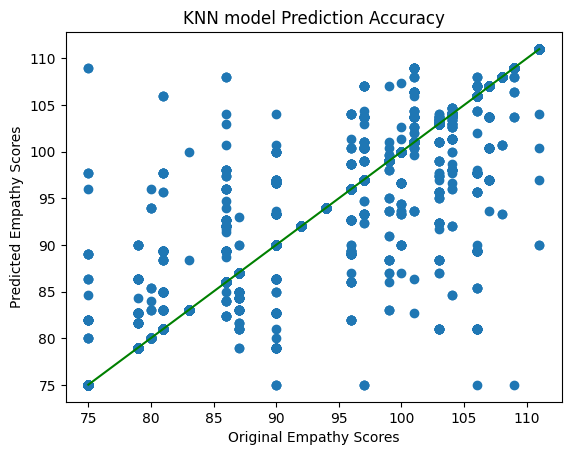

In [31]:
#creating a scatter plot
plt.scatter(y_test,y_pred)
#line of best fit
plt.plot (np.unique (y_test), np.poly1d (np.polyfit (y_test,y_pred, 1))(np.unique (y_test)), color = 'green') 
plt.title('KNN model Prediction Accuracy')
plt.xlabel('Original Empathy Scores')
plt.ylabel('Predicted Empathy Scores')
plt.show()

In [35]:
# Importing necessary libraries
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler

# Scaling the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating a Stochastic Gradient Descent Regressor
sgd = SGDRegressor()

# Training the model on the training data
sgd.fit(X_train, y_train)

# Making predictions on the test data
y_pred = sgd.predict(X_test)

# Evaluating the model
print('Training Score:', sgd.score(X_train,y_train))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('RMSE: ',mean_squared_error(y_test, y_pred, squared= False))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))


Training Score: 0.32399208685378644
MAE:  7.776819489138976
RMSE:  9.22942705354254
Explained Variance Score: 0.324415491140402
